## Crowdedness of gym prediction
With this data, we attempt to predict the best time to go to the gym based on the number of people at the gym 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
gym = pd.read_csv("crowdness_gym_data.csv")
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


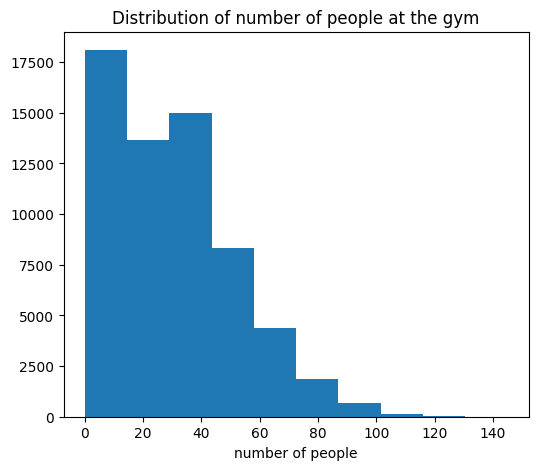

In [4]:
plt.figure(figsize=(6,5))
plt.hist(gym['number_people'])
plt.title('Distribution of number of people at the gym')
plt.xlabel('number of people')
plt.show()

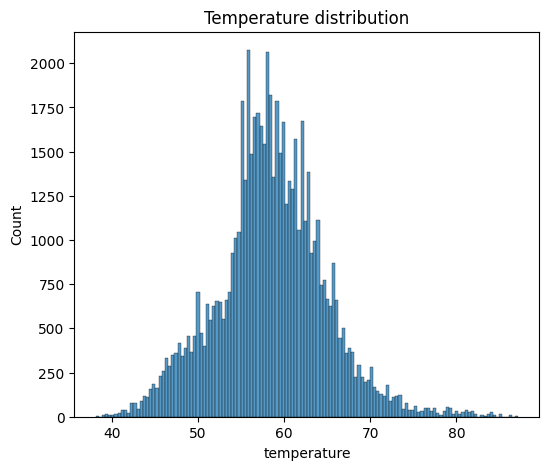

In [5]:
plt.figure(figsize=(6,5))
sns.histplot(data=gym, x='temperature')
plt.title('Temperature distribution')
plt.show()

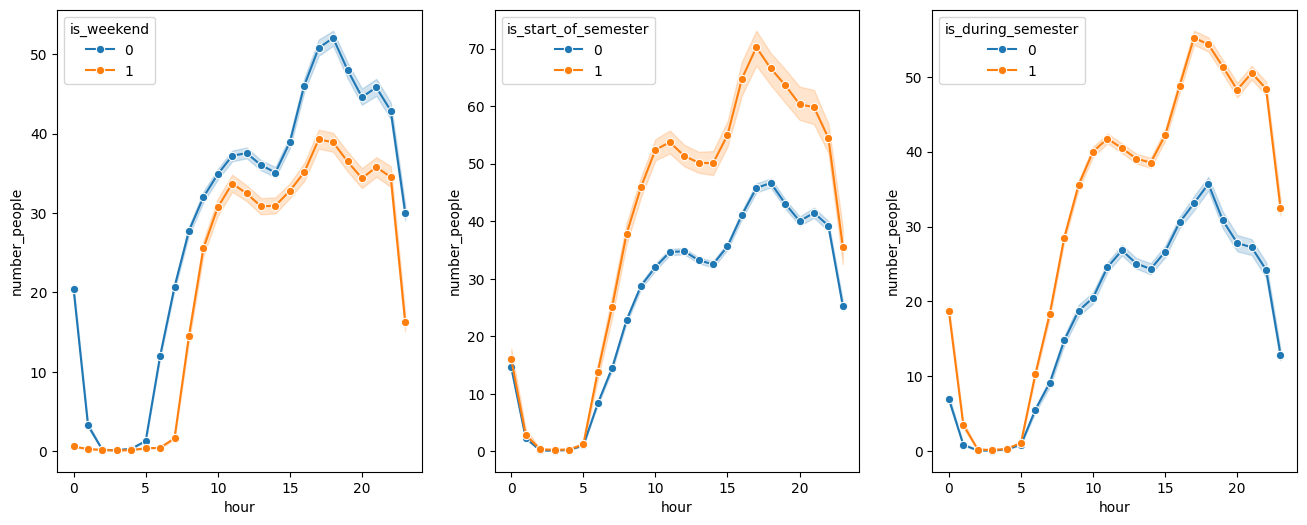

In [6]:
hues = ['is_weekend', 'is_start_of_semester', 'is_during_semester']
fig = plt.figure(figsize=(16,6))
for idx, item in enumerate(hues):
    ax = plt.subplot(1, 3, idx+1)
    sns.lineplot(data=gym, x='hour', y='number_people', hue=item, marker='o',ax=ax)
plt.show()

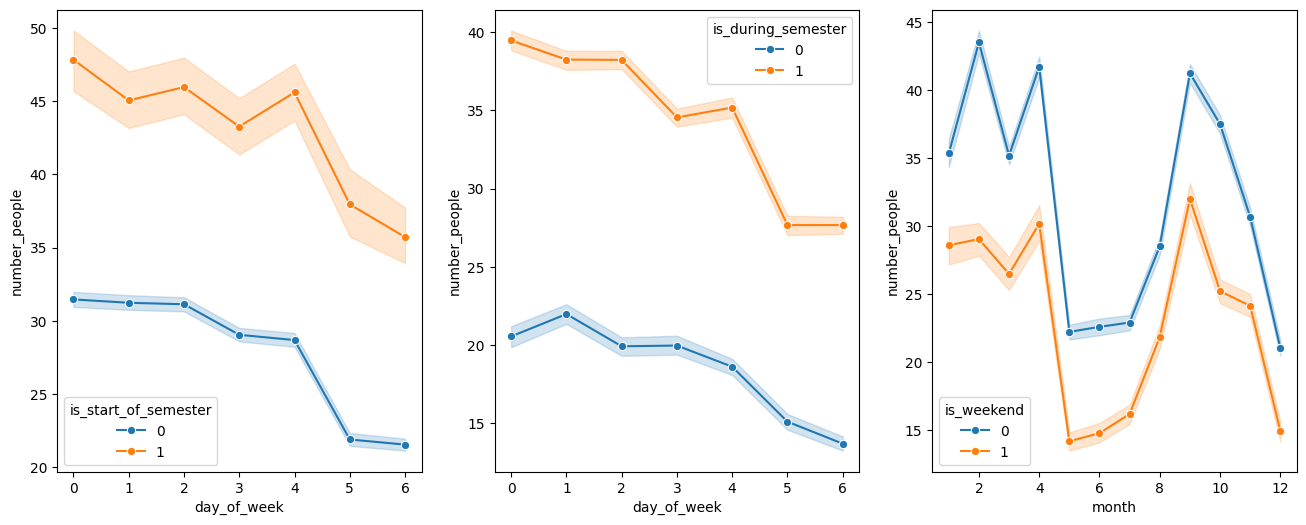

In [7]:
hues = ['is_start_of_semester', 'is_during_semester']
fig = plt.figure(figsize=(16,6))
for idx, item in enumerate(hues):
    ax = plt.subplot(1, 3, idx+1)
    sns.lineplot(data=gym, x='day_of_week', y='number_people', hue=item, marker='o',ax=ax)

ax = plt.subplot(1, 3, 3)
sns.lineplot(data=gym, x='month', y='number_people', hue='is_weekend', marker='o', ax=ax)
plt.show()

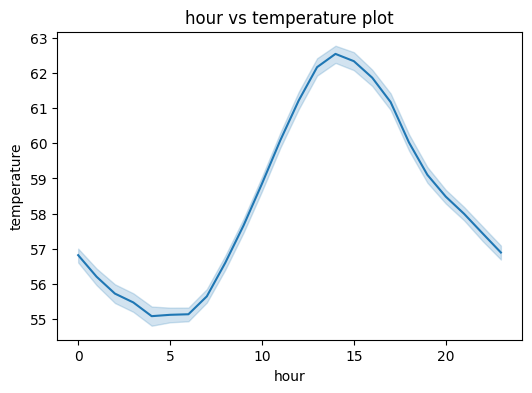

In [8]:
plt.figure(figsize=(6,4))
sns.lineplot(data=gym, x='hour', y='temperature')
plt.title('hour vs temperature plot')
plt.show()

In [9]:
corr = abs(gym.corr(numeric_only=True))
corr

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
number_people,1.000000,0.550218,0.162062,0.173958,0.048249,0.373327,0.182683,0.335350,0.097854,0.552049
timestamp,0.550218,1.000000,0.001793,0.000509,0.002851,0.184849,0.009551,0.044676,0.023221,0.999077
day_of_week,0.162062,0.001793,1.000000,0.791338,0.075862,0.011169,0.011782,0.004824,0.015559,0.001914
is_weekend,0.173958,0.000509,0.791338,1.000000,0.031899,0.020673,0.016646,0.036127,0.008462,0.000517
is_holiday,0.048249,0.002851,0.075862,0.031899,1.000000,0.088527,0.014858,0.070798,0.094942,0.002843
temperature,0.373327,0.184849,0.011169,0.020673,0.088527,1.000000,0.093242,0.152476,0.063125,0.185121
is_start_of_semester,0.182683,0.009551,0.011782,0.016646,0.014858,0.093242,1.000000,0.209862,0.137160,0.010091
is_during_semester,0.335350,0.044676,0.004824,0.036127,0.070798,0.152476,0.209862,1.000000,0.096556,0.045581
month,0.097854,0.023221,0.015559,0.008462,0.094942,0.063125,0.137160,0.096556,1.000000,0.023624
hour,0.552049,0.999077,0.001914,0.000517,0.002843,0.185121,0.010091,0.045581,0.023624,1.000000


Based on the EDA, the number of people in the gym is skewed to the left and the temp is a normal distribution. We can take a log of number of people to get a normal distribution of the outcome.  
The hour of the day and temperature columns have significant correlations the outcome the data. However, the correlations with day of week and is weekend are similar, and similar correlations are seen with is start of semester and during semester.  
therefore, the temperature column, hour and during semester columns shall be selected for model.   
As expected, the temperature varies with the hour of the day, an interaction term will be created for this data before modelling. 

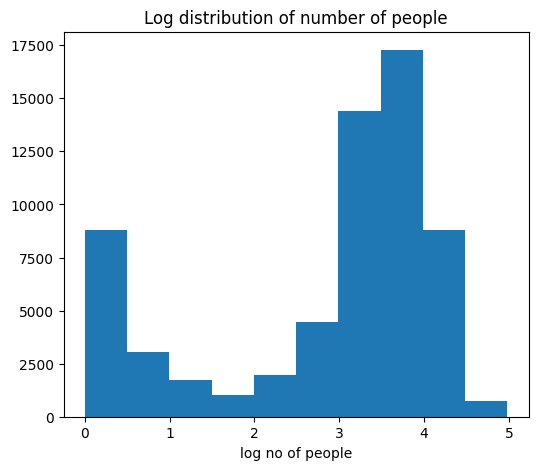

In [10]:
log_number_people = np.log1p(gym['number_people'])
gym['log_num_people'] = log_number_people

plt.figure(figsize=(6,5))
plt.hist(log_number_people)
plt.title('Log distribution of number of people')
plt.xlabel('log no of people')
plt.show()

##### Fitting the model

In [11]:
#creating interaction terms column
gym['hour_temp'] = gym['hour'] * gym['temperature']

numeric_cols = ['temperature', 'hour', 'hour_temp']
cat_cols = ['is_during_semester']

model_cols = ['temperature', 'hour', 'hour_temp', 'is_during_semester']
X = gym[model_cols]
y = gym['log_num_people']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[numeric_cols])
X_train_scaled_df = pd.DataFrame(X_train_scaled_num, columns=numeric_cols)



In [12]:
## investigating interaction terms
vif = [variance_inflation_factor(X_train_scaled_df.values, i) for i in range(X_train_scaled_df.shape[1])]
for data in zip(vif, X_train_scaled_df.columns):
    print(data)

(np.float64(5.67767852866662), 'temperature')
(np.float64(107.81004616081113), 'hour')
(np.float64(120.59332908021982), 'hour_temp')


The original values of hour and temperature will be used for the model due to unacceptable VIF from the data interaction terms

In [13]:
numeric_cols = ['temperature', 'hour']
cat_cols = ['is_during_semester']

model_cols = ['temperature', 'hour', 'is_during_semester']
X = gym[model_cols]
y = gym['log_num_people']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[numeric_cols])
X_train_scaled_df = pd.DataFrame(X_train_scaled_num, columns=numeric_cols)
X_train_final = pd.concat([X_train_scaled_df, X_train[cat_cols].reset_index(drop=True)], axis=1)

model = SGDRegressor(learning_rate='constant', eta0=1e-4, tol=1e-4, random_state=5)
model.fit(X_train_final, y_train)
train_pred_log = model.predict(X_train_final)

train_MSE_log = mean_squared_error(y_train, train_pred_log)
train_MAE_log = mean_absolute_error(y_train , train_pred_log)
train_r2_log = r2_score(y_train, train_pred_log)

print(f'training log MSE: {train_MSE_log}')
print(f'training log MAE: {train_MAE_log}')
print(f'training log R2: {train_r2_log}')



training log MSE: 1.1155009401737603
training log MAE: 0.8201478124707551
training log R2: 0.44855229563566945


In [14]:
train_mse = np.expm1(train_MSE_log)
train_mae = np.expm1(train_MAE_log)
train_r2 = np.expm1(train_r2_log)

print(f'train MSE: {train_mse}')
print(f'train MAE: {train_mae}')
print(f'train R2: {train_r2}')

train MSE: 2.051096213091089
train MAE: 1.2708354705280005
train R2: 0.5660433757737227


the traning MSE and MAE indicated the model is not as robust as expected and this can be seen from the R2 score. however because these are from the training data, we will see how they change on the test data.

In [15]:
## scaling the test data
X_test_scaled_num = scaler.transform(X_test[numeric_cols])
X_test_scaled_df = pd.DataFrame(X_test_scaled_num, columns=numeric_cols)
X_test_final = pd.concat([X_test_scaled_df, X_test[cat_cols].reset_index(drop=True)], axis=1)

test_pred_log = model.predict(X_test_final)

test_MSE_log = mean_squared_error(y_test, test_pred_log)
test_MAE_log = mean_absolute_error(y_test, test_pred_log)
test_r2_log = r2_score(y_test, test_pred_log)

print(f'test log MSE: {test_MSE_log}')
print(f'test log MAE: {test_MAE_log}')
print(f'test log R2: {test_r2_log}')

test log MSE: 1.13676889481009
test log MAE: 0.8310313907404959
test log R2: 0.44074303784423163


In [16]:
test_mse = np.expm1(test_MSE_log)
test_mae = np.expm1(test_MAE_log)
test_r2 = np.expm1(test_r2_log)

print(f'test MSE: {test_mse}')
print(f'test MAE: {test_mae}')
print(f'test R2: {test_r2}')

test MSE: 2.1166817519233736
test MAE: 1.2956852681755984
test R2: 0.553861367470778


Both train and test MSE, MAE and R2 are similar meaning our model didn't perform any better neither did perform worse

We will visualize the predictions of the model for better understanding 

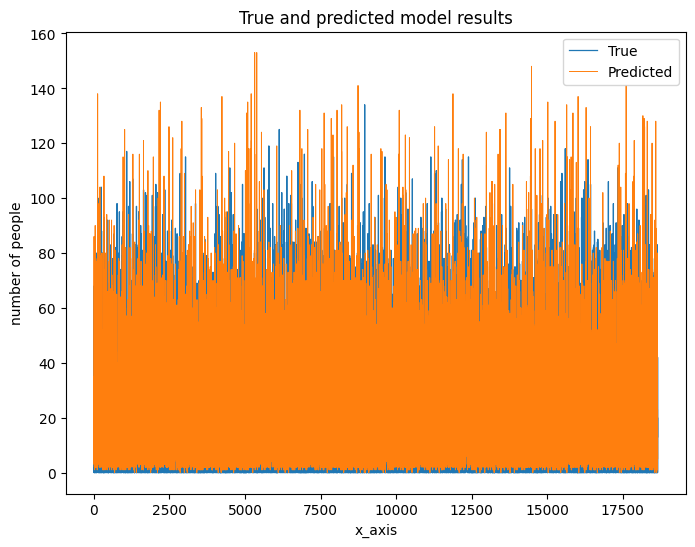

In [17]:
# traonforming the predicted test results 
y_pred = np.round(np.expm1(test_pred_log),0)
y_true = np.expm1(y_test)

plt.figure(figsize=(8, 6))
plt.title('True and predicted model results')
sns.lineplot(x=range(len(y_pred)), y=y_true, linewidth=0.9, label='True')
sns.lineplot(x=range(len(y_pred)), y=y_pred, linewidth=0.7, label='Predicted')
plt.ylabel('number of people')
plt.xlabel('x_axis')
plt.show()

#### Conclusion

Looking at the plot of the predicted versus the True values, there are some similarity between the true values and predicted values however, the model seem to overpredict the data. 

There are some improvements that can be made on the model for more robustness. 
Based on this model alone, the best to go the gym would be 5 and 10am.